In [160]:
#!pip install scapy
#!pip install pandas
#!pip install matplotlib
#!pip install networkx
#!pip install polars
#!pip install pyarrow
#!pip install aspose-diagram-python 
#!pip install seaborn

In [161]:
from scapy.all import * # Packet manipulation
import polars as pl # Pandas - Create and Manipulate DataFrames
from datetime import datetime # Datetime - Convert Epoch to Datetime
import ipaddress # IPAddress - Check for multicast and broadcast addresses
import time # Measure time it takes to run
import csv # CSV - Write to CSV
import re # Regex for name generation of files
import queue # Queue - Used for threading
from threading import Thread # Threading - Run multiple functions at once
import networkx as nx # NetworkX - Create and Manipulate Graphs
import matplotlib.pyplot as plt # Matplotlib - Plot Graphs
import os # OS - Check if file exists
import seaborn as sns # Seaborn - Plot Graphs


In [162]:
pcap_name = "The Ultimate PCAP v20221220.pcapng"
csv_file_name = re.sub(r'[^\w\s]', '', pcap_name).replace(" ", "_") + ".csv"
parquet_file_name = re.sub(r'[^\w\s]', '', pcap_name).replace(" ", "_") + ".parquet"

In [163]:
protocol_to_numbers = {'hopopt': 0, 'icmp': 1, 'igmp': 2, 'ggp': 3, 'ipv4': 4, 'st': 5, 'tcp': 6, 'cbt': 7, 
    'egp': 8, 'igp': 9, 'bbn-rcc-mon': 10, 'nvp-ii': 11, 'pup': 12, 'emcon': 14, 'xnet': 15, 'chaos': 16, 'udp': 17, 'mux': 18,
    'dcn-meas': 19, 'hmp': 20, 'prm': 21, 'xns-idp': 22, 'trunk-1': 23, 'trunk-2': 24, 'leaf-1': 25, 'leaf-2': 26, 'rdp': 27, 
    'irtp': 28, 'iso-tp4': 29, 'netblt': 30, 'mfe-nsp': 31, 'merit-inp': 32, 'dccp': 33, '3pc': 34, 'idpr': 35, 'xtp': 36, 
    'ddp': 37, 'idpr-cmtp': 38, 'tp++': 39, 'il': 40, 'ipv6': 41, 'sdrp': 42, 'ipv6-route': 43, 'ipv6-frag': 44, 'idrp': 45,
    'rsvp': 46, 'gre': 47, 'dsr': 48, 'bna': 49, 'esp': 50, 'ah': 51, 'i-nlsp': 52, 'narp': 54, 'mobile': 55, 'tlsp': 56, 
    'skip': 57, 'ipv6-icmp': 58, 'ipv6-nonxt': 59, 'ipv6-opts': 60, 'cftp': 62, 'sat-expak': 64, 'kryptolan': 65, 'rvd': 66,
    'ippc': 67, 'sat-mon': 69, 'visa': 70, 'ipcv': 71, 'cpnx': 72, 'cphb': 73, 'wsn': 74, 'pvp': 75, 'br-sat-mon': 76, 
    'sun-nd': 77, 'wb-mon': 78, 'wb-expak': 79, 'iso-ip': 80, 'vmtp': 81, 'secure-vmtp': 82, 'vines': 83, 'ttp': 84,
    'iptm': 84, 'nsfnet-igp': 85, 'dgp': 86, 'tcf': 87, 'eigrp': 88, 'ospfigp': 89, 'sprite-rpc': 90,
    'larp': 91, 'mtp': 92, 'ax.25': 93, 'ipip': 94, 'scc-sp': 96, 'etherip': 97, 'encap': 98, 'gmtp': 100, 
    'ifmp': 101, 'pnni': 102, 'pim': 103, 'aris': 104, 'scps': 105, 'qnx': 106, 'a/n': 107, 'ipcomp': 108, 
    'snp': 109, 'compaq-peer': 110, 'ipx-in-ip': 111, 'vrrp': 112, 'pgm': 113, 'l2tp': 115, 'ddx': 116, 'iatp': 117, 
    'stp': 118, 'srp': 119, 'uti': 120, 'smp': 121, 'ptp': 123, 'fire': 125, 'crtp': 126, 'crudp': 127, 'sscopmce': 128, 
    'iplt': 129, 'sps': 130, 'pipe': 131, 'sctp': 132, 'fc': 133, 'rsvp-e2e-ignore': 134, 'udplite': 136, 'mpls-in-ip': 137,
      'manet': 138, 'hip': 139, 'shim6': 140, 'wesp': 141, 'rohc': 142, 'ethernet': 143, 'aggfrag': 144, 'rsvp-e2e': 145}

# https://www.iana.org/assignments/protocol-numbers/protocol-numbers.xhtml

def get_protocol_name(protocol_number):
    for protocol_name, number in protocol_to_numbers.items():
        if number == protocol_number:
            return protocol_name
    return "Unknown"

In [164]:
class PCAPToDataFrame:
    def __init__(self, pcap_name, parquet_file_name, csv_file_name):
        self.capture_file = pcap_name
        self.parquet_file = parquet_file_name
        
        # Create new CSV file and remove old one
        self.csv_file_name = csv_file_name
        self.headers = ["time","src_ip","src_mac","dst_ip","dst_mac","protocol","payload_size","multicast","private_to_private","dst_broadcast","src_port","dst_port"]
        if os.path.exists(self.csv_file_name):
            os.remove(self.csv_file_name)

        self.queue = []
        self.batch_size = 5000  # Number of packets to buffer before writing to file

    def write_to_csv(self):
        with open(self.csv_file_name, 'a') as f:
            writer = csv.DictWriter(f, fieldnames=self.headers)
            writer.writeheader()
            while self.queue:
                data = self.queue.pop(0)
                if data is None:
                    break
                writer.writerow(data)

    # Check if ip is multicast and private>private and broadcast
    def check_multicast_and_private(self, packet, data):
        src_ip = ipaddress.ip_address(packet[IP].src)
        dst_ip = ipaddress.ip_address(packet[IP].dst)
        if src_ip.is_multicast or dst_ip.is_multicast:
            data["multicast"] = True
        if src_ip.is_private and dst_ip.is_private:
            data["private_to_private"] = True
        if not dst_ip.is_global and dst_ip.is_link_local:
            data["dst_broadcast"] = True
        else:
            data["multicast"] = False
            data["private_to_private"] = False
        data["dst_broadcast"] = False

    # Extract the port numbers
    def extract_port_numbers(self, packet, data):
        if packet.haslayer(TCP):
            data["src_port"] = int(packet[TCP].sport)
            data["dst_port"] = int(packet[TCP].dport)
        elif packet.haslayer(UDP):
            data["src_port"] = int(packet[UDP].sport)
            data["dst_port"] = int(packet[UDP].dport)

    # Extract the conversations from the packet
    def conversations_extract(self, packet):

        # Check if the packet has the IP and Ethernet layers
        if not packet.haslayer(IP) or not packet.haslayer(Ether):
            return
        
        # Convert the timestamp to a readable UTC time
        #time = datetime.utcfromtimestamp(int(packet.time)).strftime('%Y-%m-%d %H:%M:%S')
        time = datetime.utcfromtimestamp(int(packet.time)).isoformat()
        protocol = get_protocol_name(int(packet[IP].proto))

        # Extract the desired data from the packet
        data = {
            "time": time,
            "src_ip": packet[IP].src,
            "src_mac": packet[Ether].src,
            "dst_ip": packet[IP].dst,
            "dst_mac": packet[Ether].dst,
            "protocol": protocol,
            "payload_size": len(packet[IP].payload)
        }

        # Extract
        self.check_multicast_and_private(packet, data)
        self.extract_port_numbers(packet, data)

        # Add the data to the queue
        self.queue.append(data)

        # If the queue is full, write the data to the CSV file
        if len(self.queue) >= self.batch_size:
            self.write_to_csv()

    def read_pcap_to_dataframe(self):
        # Start time to read pcap time
        start_time = time.time()

        # Read the PCAP file and extract the data from each packet using the conversations_extract function
        # Use a queue to write the data to a CSV file      
        for packet in PcapReader(self.capture_file):
            self.conversations_extract(packet)
        self.write_to_csv()  # Write any remaining data to the file

        # Remove any previous parquet file
        if os.path.exists(self.parquet_file):
            os.remove(self.parquet_file)

        # Open the CSV file and convert it to a Polars dataframe
        conversations_df = pl.read_csv(self.csv_file_name, ignore_errors=True, parse_dates=True, infer_schema_length=10)
        conversations_df.write_parquet(self.parquet_file, compression='brotli')

        # Remove the CSV file
        if os.path.exists(self.csv_file_name):
            os.remove(self.csv_file_name)
        '''
        File size differences using test 12mb pcap file:
        12M  | pcapng
        2.6M | csv
        65K | parquet
        '''
        # Record time taken to process the PCAP file
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f'Elapsed time: {elapsed_time} seconds')

In [165]:
# Create an instance of the PCAPToDataFrame class
pcap_to_df = PCAPToDataFrame(pcap_name, parquet_file_name, csv_file_name)

# Read the PCAP file and create a csv
pcap_to_df.read_pcap_to_dataframe()

Elapsed time: 11.512575149536133 seconds


In [166]:
df = pl.read_parquet(parquet_file_name)
df.head(5)

time,src_ip,src_mac,dst_ip,dst_mac,protocol,payload_size,multicast,private_to_private,dst_broadcast,src_port,dst_port
datetime[μs],str,str,str,str,str,i64,bool,bool,bool,i64,i64
2012-12-11 19:26:02,"""10.0.0.1""","""c2:3d:19:6c:00...","""224.0.0.2""","""01:00:5e:00:00...","""udp""",42,false,false,false,646,646
2012-12-11 19:26:02,"""10.0.0.1""","""c2:3d:19:6c:00...","""224.0.0.2""","""01:00:5e:00:00...","""udp""",42,false,false,false,646,646
2012-12-11 19:26:02,"""10.0.0.2""","""c2:3c:19:6c:00...","""224.0.0.2""","""01:00:5e:00:00...","""udp""",42,false,false,false,646,646
2012-12-11 19:26:02,"""10.0.0.2""","""c2:3c:19:6c:00...","""224.0.0.2""","""01:00:5e:00:00...","""udp""",42,false,false,false,646,646
2012-12-11 19:26:06,"""10.0.0.2""","""c2:3c:19:6c:00...","""224.0.0.5""","""01:00:5e:00:00...","""ospfigp""",60,false,false,false,null,null


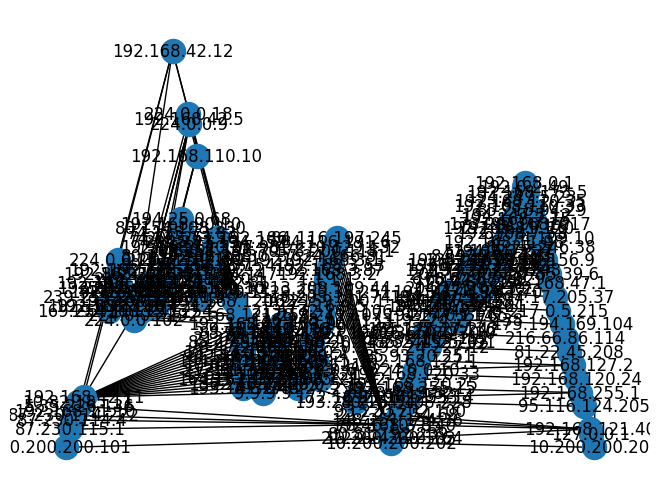

In [171]:
expression_df = (
    df.lazy()
    .filter(pl.col("private_to_private") == False)
    .select(["src_ip", "dst_ip"])
)
result_df = expression_df.collect()
result_df.head(5)
G = nx.Graph()
G = nx.from_pandas_edgelist(result_df, 'src_ip', 'dst_ip', create_using=nx.Graph())
nx.draw_planar(G, with_labels = True) 


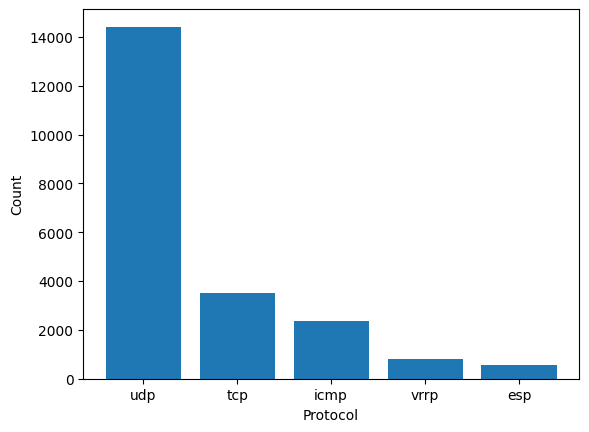

In [168]:
# Plot the number of packets per protocol
q = (
    df.lazy()
    .groupby("protocol")
    .agg(pl.count())
    .sort("count", reverse=True)
    .limit(5)
)

df_proto_top = q.collect()
plt.bar(df_proto_top['protocol'], df_proto_top['count'])
plt.xlabel('Protocol')
plt.ylabel('Count')
plt.show()

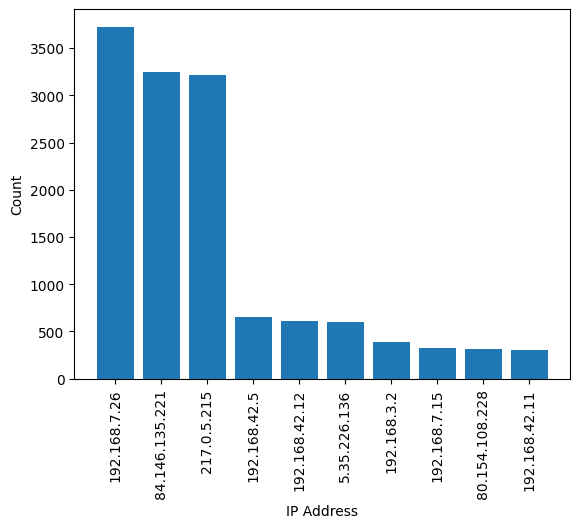

In [169]:
q = (
    df.lazy()
    .groupby(["src_ip","dst_ip"])
    .agg(pl.count())
    .sort("count", reverse=True)
    .limit(10)
)

df_top_talkers = q.collect()
x = df_top_talkers["src_ip"] #or df["dst_ip"]
y = df_top_talkers["count"]

plt.bar(x, y)
plt.xlabel('IP Address')
plt.ylabel('Count')
plt.xticks(rotation = 90) # this will rotate the x-axis labels
plt.show()